<a href="https://colab.research.google.com/github/Pratik1603/Generating-Radiologically-Realistic-Lung-Images-with-Generative-Adversarial-Networks-Minor-Project/blob/main/Minor_Project_Generating_Lung_Images_GAN_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import layers, models, optimizers

In [ ]:
def load_images(folder, img_width, img_height):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img_width, img_height))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)
        images.append(img)
    return np.array(images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_width, img_height = 64, 64
channels = 1  # Grayscale

dataset_dir = "/content/drive/My Drive/Lung dataset/archive"
!ls "/content/drive/My Drive/Lung dataset/archive"
# Load and preprocess images from the dataset
normal_images = load_images(os.path.join(dataset_dir, "chest_xray/train/NORMAL"), img_width, img_height)
pneumonia_images = load_images(os.path.join(dataset_dir, "chest_xray/train/PNEUMONIA"), img_width, img_height)

chest_xray		     lungs_generator_weights2.h5  lungs_generator_weights_wgan_gp1.h5
lungs_generator_weights1.h5  lungs_generator_weights.h5   lungs_generator_weights_wgan_gp.h5


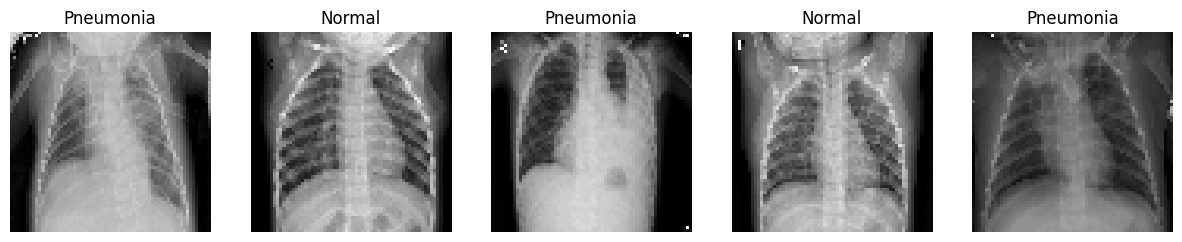

In [ ]:
# Function to load and preprocess images with labels
def load_images_with_labels(folder, img_width, img_height, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img_width, img_height))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess images with labels
normal_images, normal_labels = load_images_with_labels(os.path.join(dataset_dir, "chest_xray/train/NORMAL"), img_width, img_height, label="Normal")
pneumonia_images, pneumonia_labels = load_images_with_labels(os.path.join(dataset_dir, "chest_xray/train/PNEUMONIA"), img_width, img_height, label="Pneumonia")


real_data = np.concatenate((normal_images, pneumonia_images), axis=0)
real_labels = np.concatenate((normal_labels, pneumonia_labels), axis=0)


shuffled_indices = np.random.permutation(len(real_data))
real_data = real_data[shuffled_indices]
real_labels = real_labels[shuffled_indices]


def display_images_with_labels(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i][:, :, 0], cmap='gray')
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()


num_samples_to_display = 5
display_images_with_labels(real_data, real_labels, num_samples_to_display)


In [ ]:
# Vanilla GAN model
def build_generator(latent_dim):

    # model = models.Sequential()
    # model.add(layers.Dense(128 * 16 * 16, input_dim=latent_dim))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Reshape((16, 16, 128)))
    # model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Conv2D(channels, (7, 7), activation='sigmoid', padding='same'))
    # return model
    model = models.Sequential()
    model.add(layers.Dense(128 * 16 * 16, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((16, 16, 128)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(channels, (7, 7), activation='sigmoid', padding='same'))
    return model

# Define the Discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

latent_dim = 100
input_shape = (img_width, img_height, channels)

# Build and compile the discriminator
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim)

# Build the GAN
gan = build_gan(generator, discriminator)

gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001, beta_1=0.5))
vgan_losses = {'discriminator_loss': [], 'generator_loss': []}
# Train the GAN
def train_gan(generator, discriminator, gan, real_data, epochs, batch_size,save_path):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_images = real_data[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_labels)
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = gan.train_on_batch(noise, real_labels)
        print(f"Epoch {epoch}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")
        vgan_losses['discriminator_loss'].append(discriminator_loss[0])
        vgan_losses['generator_loss'].append(generator_loss)
        if epoch % 1000 == 0:
          save_images(generator.predict(np.random.normal(0, 1, (25,latent_dim))), path=f"/content/drive/My Drive/Lung dataset/generated_imagesImproved/epoch_{epoch}")
    generator.save_weights(save_path)

epochs=10000
batch_size=64
def save_images(images, path='/content/drive/My Drive/generated_imagesImproved/'):
    os.makedirs(path, exist_ok=True)
    for i, image in enumerate(images):
        plt.imshow(image)
        plt.axis('off')
        plt.savefig(f"{path}generated_image_{i}.png")
        plt.close()

train_gan(generator, discriminator, gan, real_data, epochs, batch_size,'/content/drive/My Drive/Lung dataset/archive/lungs_generator_weights2.h5')


2/2 [==============================] - 3s 1s/step
Epoch 0, Discriminator Loss: 1.0021967887878418, Generator Loss: 0.574694037437439
2/2 [==============================] - 2s 1s/step
Epoch 1, Discriminator Loss: 0.6973318755626678, Generator Loss: 0.6729533672332764
2/2 [==============================] - 2s 1s/step
Epoch 2, Discriminator Loss: 0.6854882538318634, Generator Loss: 0.7258588671684265
2/2 [==============================] - 2s 1s/step
Epoch 3, Discriminator Loss: 0.6670399904251099, Generator Loss: 0.7758061289787292
2/2 [==============================] - 1s 764ms/step
Epoch 4, Discriminator Loss: 0.6551263630390167, Generator Loss: 0.8197875618934631
2/2 [==============================] - 1s 680ms/step
Epoch 5, Discriminator Loss: 0.632493644952774, Generator Loss: 0.8711264729499817
2/2 [==============================] - 1s 718ms/step
Epoch 6, Discriminator Loss: 0.6086730659008026, Generator Loss: 0.9398646354675293
2/2 [==============================] - 1s 678ms/step
Ep

KeyboardInterrupt: 

In [ ]:
saved_model_path = "/content/drive/MyDrive/Lung dataset/archive/lungs_generator_weights2.h5"
model = tf.keras.models.load_model(saved_model_path)
training_history = model.history.history

# Get generator and discriminator losses
generator_loss = training_history['generator_loss']
discriminator_loss = training_history['discriminator_loss']

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x7c1681f1bdc0>.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 64, 64, 128)       262272    
 Transpose)                                           

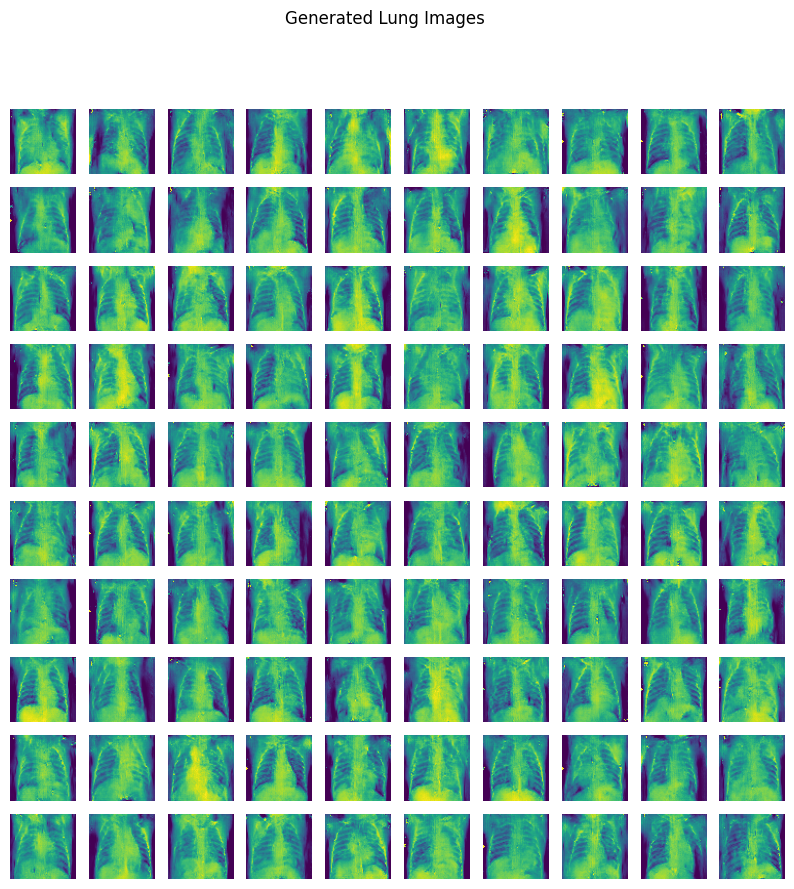

In [ ]:
#GAN model
def build_generatorSimple(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128 * 16 * 16, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((16, 16, 128)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(channels, (7, 7), activation='sigmoid', padding='same'))
    return model
def display_generated_images(generator, z_dim, num_images, title):
    random_latent_vectors = np.random.normal(0, 1, (num_images, z_dim))
    generated_images = generator.predict(random_latent_vectors)

    # Rescale images to the [0,1] range
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i, :, :, :])
        plt.axis('off')

    plt.suptitle(title)
    plt.show()


generator_lungs = build_generatorSimple(latent_dim)
generator_lungs.load_weights('/content/drive/My Drive/Lung dataset/archive/lungs_generator_weights.h5')
print(generator_lungs.summary())
# Generate and display cat images
display_generated_images(generator_lungs, latent_dim, 100, 'Generated Lung Images')

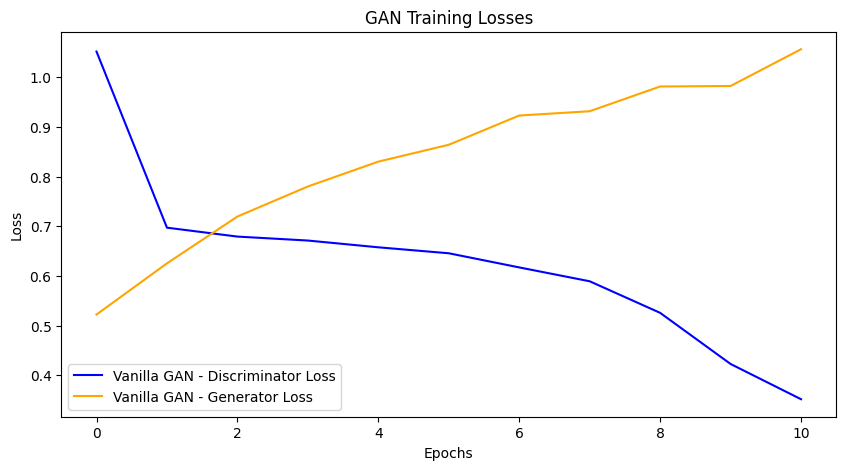

In [ ]:
# for epoch in range(epochs):

plt.figure(figsize=(10, 5))

    # Plot Vanilla GAN losses
plt.plot(vgan_losses['discriminator_loss'], label='Vanilla GAN - Discriminator Loss', color='blue')
plt.plot(vgan_losses['generator_loss'], label='Vanilla GAN - Generator Loss', color='orange')



plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()

In [ ]:
#WGAN model
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the generator
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128 * 16 * 16, input_dim=latent_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((16, 16, 128)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(channels, (7, 7), activation='sigmoid', padding='same'))
    return model

# Define the discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Define the gradient penalty
def gradient_penalty_loss(real_images, fake_images, discriminator):
    batch_size = tf.shape(real_images)[0]

    # Randomly interpolate between real and fake samples
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred_interpolated = discriminator(interpolated)

    gradients = tape.gradient(pred_interpolated, interpolated)
    gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean(tf.square(gradients_l2_norm - 1.0))

    return gradient_penalty

# Define the WGAN-GP model
def build_wgan_gp(generator, discriminator, latent_dim):
    z = layers.Input(shape=(latent_dim,))
    img = generator(z)
    valid = discriminator(img)
    return models.Model(z, valid)

# Define parameters
latent_dim = 100

input_shape = (img_width, img_height, channels)

# Build and compile the discriminator
discriminator = build_discriminator(input_shape)
discriminator.compile(optimizer=optimizers.RMSprop(lr=0.00005), loss='mse')

# Build the generator
generator = build_generator(latent_dim)

# Build the WGAN-GP
wgan_gp = build_wgan_gp(generator, discriminator, latent_dim)

# Compile the WGAN-GP
wgan_gp.compile(optimizer=optimizers.RMSprop(lr=0.00005), loss=lambda y_true, y_pred: -y_pred)
wgan_losses = {'discriminator_loss': [], 'generator_loss': []}
# Train the WGAN-GP
def train_wgan_gp(generator, discriminator, wgan_gp, real_data, epochs, batch_size, save_path):
    for epoch in range(epochs):
        for _ in range(batch_size):
            idx = np.random.randint(0, real_data.shape[0], batch_size)
            real_images = real_data[idx]

            # Train the discriminator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator.predict(noise)
            epsilon = np.random.uniform(0, 1, (batch_size, 1, 1, 1))
            interpolated_samples = epsilon * real_images + (1 - epsilon) * fake_images
            interpolated_samples = tf.Variable(interpolated_samples, dtype=tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(interpolated_samples)
                pred_real = discriminator(real_images)
                pred_fake = discriminator(fake_images)
                gradient_penalty = gradient_penalty_loss(real_images, fake_images,discriminator)
                d_loss = tf.reduce_mean(pred_fake) - tf.reduce_mean(pred_real) + 10 * gradient_penalty
            grads = tape.gradient(d_loss, discriminator.trainable_weights)
            discriminator.optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = wgan_gp.train_on_batch(noise, -np.ones((batch_size, 1)))

        print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
        wgan_losses['discriminator_loss'].append(d_loss)
        wgan_losses['generator_loss'].append(g_loss)
        if epoch % 20 == 0:
            save_images(generator.predict(np.random.normal(0, 1, (25, latent_dim))), path=f"/content/drive/My Drive/Lung dataset/generated_imagesWGAN1/epoch_{epoch}")

    generator.save_weights(save_path)

# Train the WGAN-GP
epochs = 1000
batch_size =64

def save_images(images, path='/content/drive/My Drive/Lung dataset/generated_imagesWGAN1'):
    os.makedirs(path, exist_ok=True)
    for i, image in enumerate(images):
        plt.imshow(image)
        plt.axis('off')
        plt.savefig(f"{path}generated_image_{i}.png")
        plt.close()
train_wgan_gp(generator, discriminator, wgan_gp, real_data, epochs, batch_size, '/content/drive/My Drive/Lung dataset/archive/lungs_generator_weights_wgan_gp1.h5')


2/2 [==============================] - 0s 19ms/step


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 13ms/step
Epoch 235, Discriminator Loss: -15.732964515686035, Generator Loss: -52.16836166381836
2/2 [==============================] - 0s 20ms/step
Epoch 236, Discriminator Loss: -10.858818054199219, Generator Loss: -44.24620056152344
2/2 [==============================] - 0s 14ms/step
Epoch 237, Discriminator Loss: -12.481012344360352, Generator Loss: -16.27528190612793
2/2 [==============================] - 0s 14ms/step
Epoch 238, Discriminator Loss: -23.979259490966797, Generator Loss: -15.890586853027344
2/2 [==============================] - 0s 14ms/step
Epoch 239, Discriminator Loss: -23.345420837402344, Generator Loss: -12.751041412353516
2/2 [==============================] - 0s 16ms/step
Epoch 240, Discriminator Loss: -29.75037384033203, Generator Loss: -12.02243423461914
2/2 [==============================] - 0s 14ms/step
Epoch 241, Discriminator Loss: -38.731571197509766, Generator 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 batch_normalization (Batch  (None, 32768)             131072    
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       262272    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       5

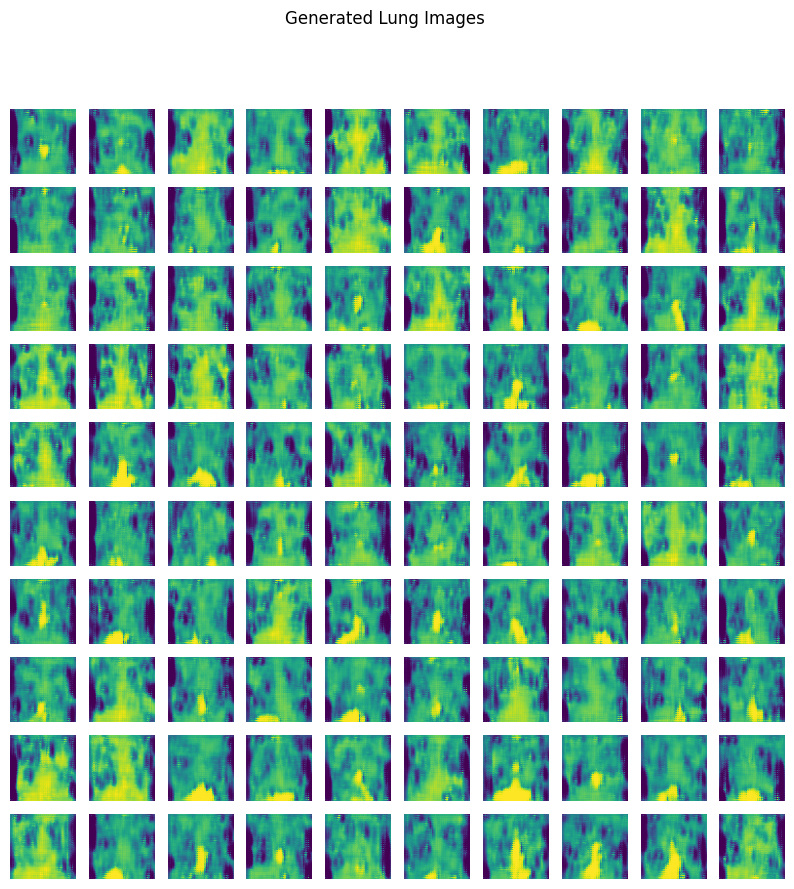

In [ ]:
latent_dim=100
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128 * 16 * 16, input_dim=latent_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((16, 16, 128)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(channels, (7, 7), activation='sigmoid', padding='same'))
    return model
def display_generated_images(generator, z_dim, num_images, title):
    random_latent_vectors = np.random.normal(0, 1, (num_images, z_dim))
    generated_images = generator.predict(random_latent_vectors)

    # Rescale images to the [0,1] range
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i, :, :, :])
        plt.axis('off')

    plt.suptitle(title)
    plt.show()


generator_lungs = build_generator(latent_dim)
generator_lungs.load_weights('/content/drive/My Drive/Lung dataset/archive/lungs_generator_weights_wgan_gp.h5')
print(generator_lungs.summary())
# Generate and display cat images
display_generated_images(generator_lungs, latent_dim, 100, 'Generated Lung Images')